Ensemble reweighting using Cryo-EM particles
============================================

This example shows how to generate synthetic cryo-EM images, and use these synthetic cryo-EM images to reweight MD simulations by Bayesian inference.

First, setup the virtual environment and install the required packages.

<!-- .. code-block:: bash -->

    git clone https://github.com/wstangfi/Ensemble-reweighting-using-Cryo-EM-particles.git
    cd Ensemble-reweighting-using-Cryo-EM-particles
    
    # Python 3.10.10
    python3 -m venv ./venv/
    source ./venv/bin/activate
    pip install --upgrade pip
    pip install -e .
    pip install --upgrade MDAnalysis
    pip install ipykernel scipy
    pip3 install torch torchvision torchaudio
    pip install --upgrade cmdstanpy

    # for Linux
    install_cmdstan

In this example, the initial set of structures (and the cluster populations) are obtained from K-Medoids clustering. Example script to perform the clustering calculation is shown at the bottom of this notebook.

We will run, analyze, and visualize along the way as we go through the process of running the Ensemble reweighting calculation.

In [3]:
## import necessary modules
import os, sys
import csv
from tqdm import tqdm
import numpy as np
import torch
from scipy.special import logsumexp

# check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import cmdstanpy
cmdstanpy.install_cmdstan()   # if you don't have cmdstan installed, uncomment this line
# cmdstanpy.rebuild_cmdstan()   # if cmdstan fails to compile, try uncommenting this line

import MDAnalysis as mda
from MDAnalysis.analysis import align

## cryoER modules
import cryoER
from cryoER import imggen_torch as igt
from cryoER.approx_lmbd import approx_lmbd
from cryoER.align_traj import align_traj
from cryoER.make_synthetic_images import make_synthetic_images
from cryoER.calc_image_struc_distance import calc_image_struc_distance
from cryoER.run_cryoER_mcmc import run_cryoER_mcmc
from cryoER.analyze_mcmc import analyze_mcmc

## test compile cmdstan model
cryoER.run_cryoER_mcmc.BuildCmdStanModel()

## cryoEM settings
n_pixel = 128       # number of pixels
pixel_size = 0.2    # pixel size in Angstrom
sigma = 1.5         # width of atom in Angstrom
snr = 1.0           # signal-to-noise ratio
defocus_min = 0.027 # minimum defocus in micron
defocus_max = 0.090 # maximum defocus in micron
nCluster = 10       # number of clusters

## plot settings
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 100

cmap_fe = 'afmhot'

## data directory
data_directory = '../data/'
## output directory
output_directory = './output/'
try:
    os.mkdir(output_directory)
except:
    # os.system('rm -rf ./output/*')
    pass

CmdStan install directory: /Users/wtang/.cmdstan
CmdStan version 2.33.1 already installed
Test model compilation


Inspecting the data

In [4]:
# Structure for generating synthetic cryo-EM data ("Ground Truth")
uImage = mda.Universe(data_directory + 'image.pdb', data_directory + 'image.xtc')
# Structure of Initial structural ensemble for reweighting (10 structures chosen by clustering)
uStruc = mda.Universe(data_directory + 'struc.pdb', data_directory + 'struc.xtc')

def mdau_to_pos_arr(u):
    protein_CA = u.select_atoms("protein and name CA")
    pos = torch.zeros((len(u.trajectory), len(protein_CA), 3), dtype=float)
    for i, ts in enumerate(u.trajectory):
        pos[i] = torch.from_numpy(protein_CA.positions)
    pos -= pos.mean(1).unsqueeze(1)
    return pos

posStruc = mdau_to_pos_arr(uStruc)
posImage = mdau_to_pos_arr(uImage)

# check center of mass
assert torch.allclose(posStruc.mean(1), torch.zeros_like(posStruc.mean(1)))
assert torch.allclose(posImage.mean(1), torch.zeros_like(posImage.mean(1)))

nStruc = posStruc.shape[0]
nImage = posImage.shape[0]

print('Number of reference structures: {}'.format(nStruc))
print('Number of images (1 synthetic image per structure): {}'.format(nImage))

Number of reference structures: 10
Number of images (1 synthetic image per structure): 5277


In [5]:
## Plotting script for 2D free energy landscape given two collective variables
def plot2DFreeEnergy(fig, cv1, cv2, weights = None, 
    nameCV1 = 'CV1', nameCV2 = 'CV2', title = None,
    cv1Min = 0, cv1Max = 10, cv2Min = 0, cv2Max = 10, 
    n_bin = 50, cmap=cmap_fe, vmin=0, vmax=6, alpha=1.0):

    xedges = np.linspace(cv1Min, cv1Max, n_bin)
    yedges = np.linspace(cv2Min, cv2Max, n_bin)
    
    if weights is None:
        H_init, xedges, yedges = np.histogram2d(cv1, cv2, bins=(xedges, yedges), density=True)
    else:
        H_init, xedges, yedges = np.histogram2d(cv1, cv2, bins=(xedges, yedges), density=True, weights=weights)
    
    y_init = -np.log(H_init)
    y_init -= np.amin(y_init)
    y_init[np.isinf(y_init)] = 1e99

    # Plot the RMSD
    xa = .5*(xedges[1:]+xedges[:-1])
    ya = .5*(yedges[1:]+yedges[:-1])

    ax = fig.add_subplot()
    ax.set_position([0.14,0.12,0.85*0.8,0.85])
    ai = ax.imshow(y_init, interpolation='none', origin='lower', cmap=cmap_fe, vmin=vmin, vmax=vmax,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='equal', alpha=alpha)

    cax = fig.add_subplot()
    cbar = fig.colorbar(ai, cax=cax, ax=ax)
    cax.set_position([0.14+0.85*0.8+0.02,0.12,0.05,0.85])
    cbar.set_label("Free Energy")

    ax.set_xlabel(nameCV2)
    ax.set_ylabel(nameCV1)

    if title is not None:
        ax.set_title(title)

    return ax

/Users/wtang/Code/git_repo/Ensemble-reweighting-using-Cryo-EM-particles/venv/lib/python3.11/site-packages/MDAnalysis/analysis/align.py:732: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)
/var/folders/_8/h5rr6k3s2995tzxt8b9sqfgh0000gq/T/ipykernel_88300/1223149080.py:15: RuntimeWarning: divide by zero encountered in log
  y_init = -np.log(H_init)


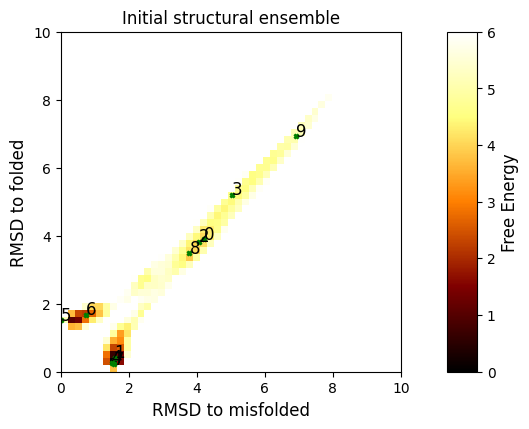

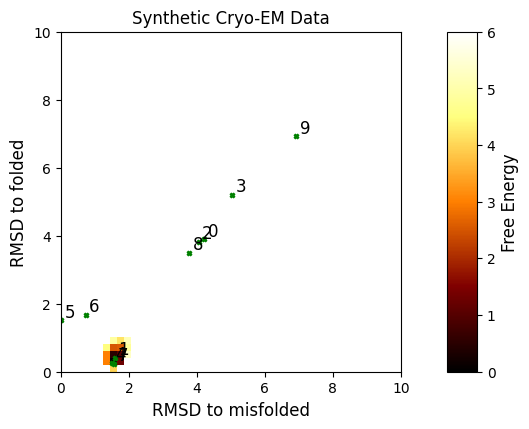

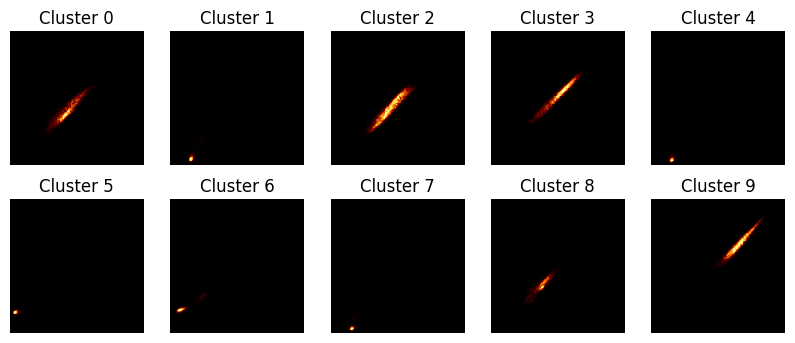

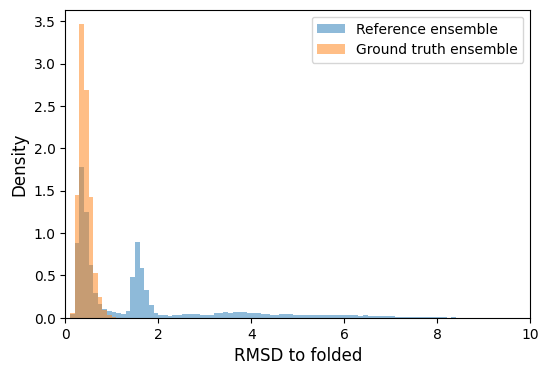

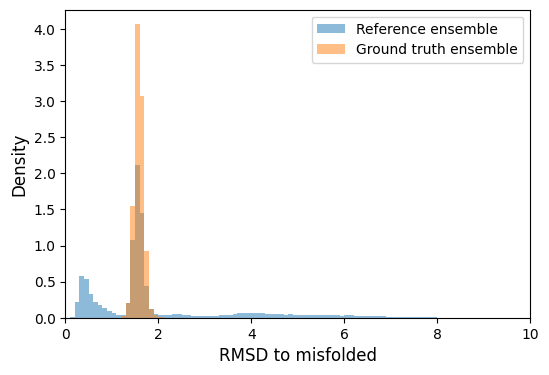

In [6]:
## Reference structures of folded and misfolded states for visualizing 2D Free Energy Landscape
uStrucFolded = mda.Universe(data_directory + 'folded.pdb')
uStrucMisfolded = mda.Universe(data_directory + 'misfolded.pdb')

## Ensure center of mass is at origin
uStrucFolded.atoms.translate(-uStrucFolded.select_atoms('protein and name CA').center_of_mass())
uStrucMisfolded.atoms.translate(-uStrucMisfolded.select_atoms('protein and name CA').center_of_mass())
uImage.atoms.translate(-uImage.select_atoms('protein and name CA').center_of_mass())
uStruc.atoms.translate(-uStruc.select_atoms('protein and name CA').center_of_mass())

## Calculate the RMSD between the first frame of the trajectory and the reference structure
rmsdImageFolded = align.AlignTraj(uImage, uStrucFolded, select='protein and name CA', in_memory=True).run().rmsd
rmsdImageMisfolded = align.AlignTraj(uImage, uStrucMisfolded, select='protein and name CA', in_memory=True).run().rmsd

rmsdStrucFolded = align.AlignTraj(uStruc, uStrucFolded, select='protein and name CA', in_memory=True).run().rmsd
rmsdStrucMisfolded = align.AlignTraj(uStruc, uStrucMisfolded, select='protein and name CA', in_memory=True).run().rmsd

## Initial structural ensemble, the origin trajectory file is not included in the data set
## We only put the CVs of the structural ensemble here for analysis and visualization of the results
## CVs of the structural ensemble where the reference structures are chosen from by clustering
rmsdTrajFolded = np.loadtxt(data_directory + 'rmsdStrucFolded.txt')
rmsdTrajMisfolded = np.loadtxt(data_directory + 'rmsdStrucMisfolded.txt')

filename_cluster_labels = data_directory + 'cluster_labels.txt'
cluster_labels = np.loadtxt(filename_cluster_labels, dtype=int)

filename_cluster_counts = data_directory + 'cluster_counts.txt'
cluster_counts = np.loadtxt(filename_cluster_counts)
nCluster = len(cluster_counts)

fig = plt.figure()
ax = plot2DFreeEnergy(fig, rmsdTrajFolded, rmsdTrajMisfolded, nameCV1 = "RMSD to folded", nameCV2 = "RMSD to misfolded", title = "Initial structural ensemble")
ax.scatter(rmsdStrucMisfolded, rmsdStrucFolded, s=10, c='g', marker='X', label='Reference structure')
for i in range(nStruc):
    ax.annotate(i, (rmsdStrucMisfolded[i], rmsdStrucFolded[i]), fontsize=12)
plt.show()

fig = plt.figure()
ax = plot2DFreeEnergy(fig, rmsdImageFolded, rmsdImageMisfolded, nameCV1 = "RMSD to folded", nameCV2 = "RMSD to misfolded", title = "Synthetic Cryo-EM Data")
ax.scatter(rmsdStrucMisfolded, rmsdStrucFolded, s=10, c='g', marker='X', label='Reference structure')
for i in range(nStruc):
    ax.annotate(i, (rmsdStrucMisfolded[i], rmsdStrucFolded[i]), xytext=(rmsdStrucMisfolded[i]+0.1, rmsdStrucFolded[i]+0.1), fontsize=12)
plt.show()

## distribution of cluster members for each cluster
fig = plt.figure(figsize=(10, 4), dpi=100)
xbins = np.linspace(0, 10, 100)
ybins = np.linspace(0, 10, 100)
for i in range(nCluster):
    ax = fig.add_subplot(2, 5, i+1)
    hist, xedges, yedges = np.histogram2d(rmsdTrajFolded[cluster_labels == i], rmsdTrajMisfolded[cluster_labels == i], bins=(xbins,ybins), density=True)
    ax.imshow(hist, cmap='afmhot', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='equal')
    ax.axis('off')
    ax.set_title('Cluster %d'%i)
plt.show()

bins = np.linspace(0,10,101)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.hist(rmsdTrajFolded, bins=bins, alpha=0.5, label='Reference ensemble', density=True)
ax.hist(rmsdImageFolded, bins=bins, alpha=0.5, label='Ground truth ensemble', density=True)
ax.set_xlabel('RMSD to folded')
ax.set_ylabel('Density')
ax.set_xlim(0,10)
ax.legend()

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.hist(rmsdTrajMisfolded, bins=bins, alpha=0.5, label='Reference ensemble', density=True)
ax.hist(rmsdImageMisfolded, bins=bins, alpha=0.5, label='Ground truth ensemble', density=True)
ax.set_xlabel('RMSD to misfolded')
ax.set_ylabel('Density')
ax.set_xlim(0,10)
ax.legend()


In [7]:
## Step 1: Calculate the rotational matrix that aligns the images to the structure, in non-synthetic data, this step would be replaced by pose estimation, e.g., in ab initio reconstruction
rot_mats_align = align_traj(
    top_image = data_directory + 'image.pdb',
    traj_image = data_directory + 'image.xtc',
    top_struc = data_directory + 'struc.pdb',
    traj_struc = data_directory + 'struc.xtc',
    outdir = output_directory,
    device = device
)
## The command line equivalent of the code:
# os.system("python3 -m cryoER.align_traj \
#     --top_image data_directoryimage.pdb \
#     --traj_image data_directoryimage.xtc \
#     --top_struc data_directorystruc.pdb \
#     --traj_struc data_directorystruc.xtc \
#     --outdir %s \
#     --device %s"%(output_directory, device))

Calculating rotation matrices...


100%|██████████| 1/1 [00:00<00:00, 13.21it/s]

Done!


In the cryoER posterior $p(\mathbf{A}|\mathbf{Y}, \mathbf{X})$
$$
    p(\mathbf{A}|\mathbf{Y}, \mathbf{X}) = \prod_{i=1}^{N_{\mathrm{image}}} \sum_{m=1}^{N_{\mathrm{struc}}} p(y_i|x_m) \cdot p(x_m|\alpha_m) 
        = \prod_{i=1}^{N_{\mathrm{image}}} \sum_{m=1}^{N_{\mathrm{struc}}} \mathcal{N}(y_i|x_m,\lambda^2) \cdot (\alpha_m N_m)
        =\prod_{i=1}^{N_{\mathrm{image}}} \sum_{m=1}^{N_{\mathrm{struc}}} \exp\left[-\frac{||y_i-F(x_m)||^2}{2\lambda^2}\right] \cdot (\alpha_m N_m),
$$
we evaluate the likelihood $p(y_i|x_m)$ before sampling the posterior for $\alpha_m$ using MCMC. We approximate $\lambda$ for evaluating the likelihood by calculating the noise standard deviation in templates given the SNR level, and calculate image-structure distance $||y_i-F(x_m)||^2$ by calculating the l2-distance between the cryo-EM image and the ``template'' generated from the reference structure along with the forward model and pose parameters.

In [8]:
## Step 2: Approximate lambda, the pixel (intensity) standard deviation used in the cryoEM likelihood
lmbd = approx_lmbd(
    top_struc = data_directory + 'struc.pdb',
    traj_struc = data_directory + 'struc.xtc',
    n_pixel = n_pixel,
    pixel_size = pixel_size,
    sigma = sigma,
    signal_to_noise_ratio = snr,
    add_ctf = True,
    defocus_min = defocus_min,
    defocus_max = defocus_max,
    n_image_per_struc = 100,
    n_batch = 10,
    device = device
)
## The command line equivalent of the code:
# os.system("python3 -m cryoER.approx_lmbd \
#     --top_struc data_directorystruc.pdb \
#     --traj_struc data_directorystruc.xtc \
#     --n_pixel %d \
#     --pixel_size %.1f \
#     --sigma %.1f \
#     --signal_to_noise_ratio %.1f \
#     --add_ctf \
#     --defocus_min %.3f \
#     --defocus_max %.3f \
#     --n_image_per_struc 100 \
#     --n_batch 1 \
#     --device cuda" % (n_pixel, pixel_size, sigma, snr, defocus_min, defocus_max))

Generating images for batch: 100%|██████████| 100/100 [00:00<00:00, 134.00it/s]

1.0 0.0010670496831685083


In [9]:
rot_mats_image, ctfs, images = make_synthetic_images(
    top_image = data_directory + 'image.pdb',
    traj_image = data_directory + 'image.xtc',
    outdir = output_directory,
    n_pixel = n_pixel,
    pixel_size = pixel_size,
    sigma = sigma,
    snr = snr,
    n_image_per_struc = 1,
    add_ctf = True,
    defocus_min = defocus_min,
    defocus_max = defocus_max,
    device = device,
    batch_size = 32
)

Reading trajectory...
Reading image trajectory from ../data/image.pdb and ../data/image.xtc...


Generating images for batch: 100%|██████████| 165/165 [00:06<00:00, 24.89it/s]


Saving images to ./output/...
Done!


In [10]:
## Step 3: Calculate the image-structure distance
diff_mat = calc_image_struc_distance(
    images = images,
    ctfs = ctfs,
    rot_mats_image = rot_mats_image,
    top_struc = data_directory + 'struc.pdb',
    traj_struc = data_directory + 'struc.xtc',
    rotmat_struc_imgstruc = '%s/rot_mats_struc_image.npy'%output_directory,
    outdir = output_directory,
    n_pixel = n_pixel,
    pixel_size = pixel_size,
    sigma = sigma,
    snr = snr,
    add_ctf = True,
    defocus_min = defocus_min,
    defocus_max = defocus_max,
    batch_size = 32
)
## The command line equivalent of the code:
# image_filename = '%s/images_npix%d_ps%.2f_s%.1f_snr%.1E.npy' % (output_directory, n_pixel, pixel_size, sigma, snr)
# ctfs_filename = '%s/ctfs_npix%d_ps%.2f_s%.1f_snr%.1E.npy' % (output_directory, n_pixel, pixel_size, sigma, snr)
# rot_mats_image_filename = '%s/rot_mats_image_npix%d_ps%.2f_s%.1f_snr%.1E.npy' % (output_directory, n_pixel, pixel_size, sigma, snr)
# os.system("python3 -m cryoER.calc_image_struc_distance \
#   --images %s
#   --ctfs %s
#   --rot_mats_image %s
#   --top_struc data_directorystruc.pdb \
#   --traj_struc data_directorystruc.xtc \
#   --rotmat_struc_imgstruc ./output/rot_mats_struc_image.npy \
#   --outdir ./output/ \
#   --n_pixel %d \
#   --pixel_size %.1f \
#   --sigma %.1f \
#   --signal_to_noise_ratio %.1f \
#   --add_ctf \
#   --defocus_min %.3f \
#   --defocus_max %.3f \
#   --n_batch 1" % (image_filename, ctfs_filename, rot_mats_image_filename, \
#       n_pixel, pixel_size, sigma, snr, defocus_min, defocus_max))

Reading trajectory from ../data/struc.pdb and ../data/struc.xtc...
Reading struc-images alignment matrices from ./output//rot_mats_struc_image.npy...


Computing image-structure distance for structure: 100%|██████████| 10/10 [00:33<00:00,  3.37s/it]

Saving...
Done!


Inspect the images

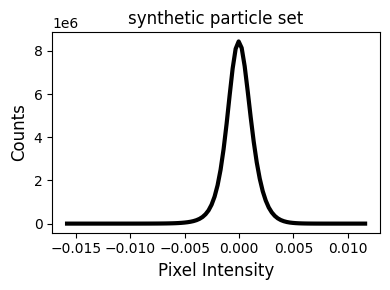

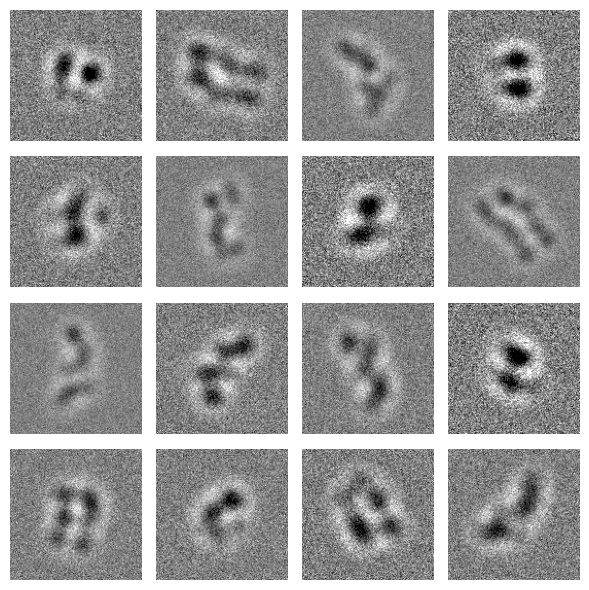

In [11]:
# Load the Synthetic images
images = np.load('%s/images_npix%d_ps%.2f_s%.1f_snr%.1E.npy' % (output_directory, n_pixel, pixel_size, sigma, snr))

## Inspect pixel intensities
fig = plt.figure(figsize=(4, 3), dpi=100)
hist, edges = np.histogram(images.flatten(), bins=100)
ax = fig.add_subplot(111)
ax.plot(edges[:-1], hist, color='k')
ax.set_xlabel('Pixel Intensity')
ax.set_ylabel('Counts')
ax.set_title('synthetic particle set')
plt.tight_layout()

## Visualize the synthetic images
fig = plt.figure(figsize=(6, 6), dpi=100)
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(images[i], cmap='gray', vmin=-5e-3, vmax=5e-3)
    ax.axis('off')
plt.tight_layout()

Inspect the image-structure distance

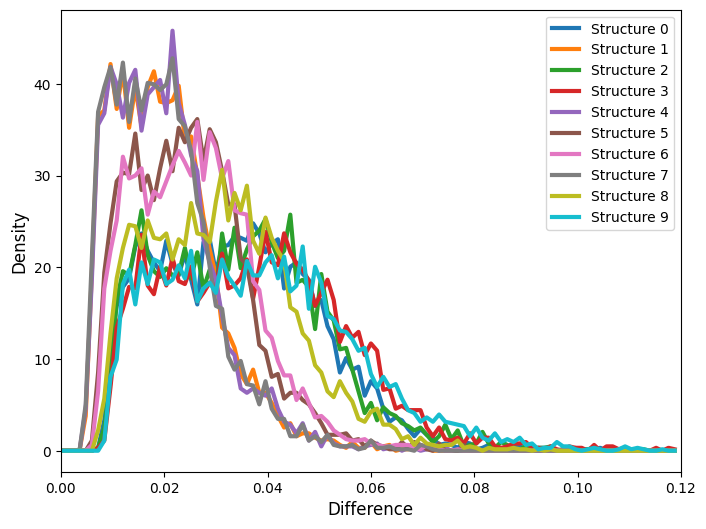

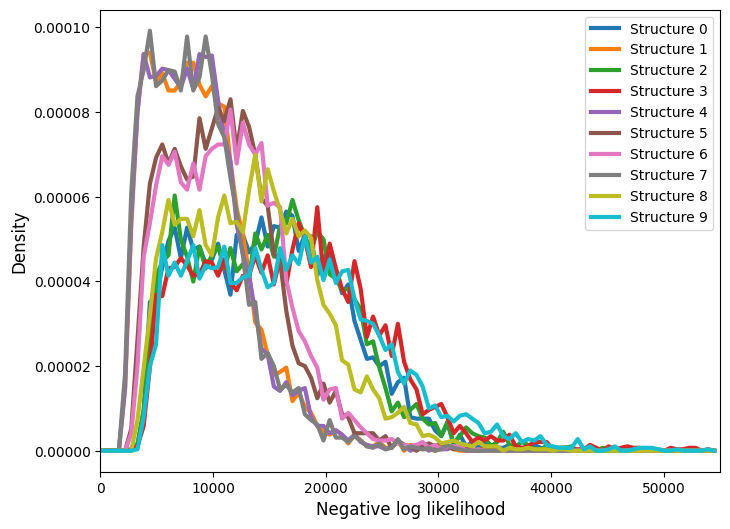

In [12]:
bins = np.linspace(0.0,0.12,101)
diff = np.load(output_directory + "diff_npix%d_ps%.2f_s%.1f_snr%.1E.npy" % (n_pixel, pixel_size, sigma, snr))
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
for i in range(nCluster):
    hist, edges = np.histogram(diff[i], bins=bins, density=True)
    ax.plot(edges[:-1], hist, label='Structure %d'%i)
ax.set_xlim(edges[0], edges[-1])
ax.set_xlabel('Difference')
ax.set_ylabel('Density')
ax.legend()

bins = np.linspace(0,55000,101)
nll = diff / (2 * lmbd**2)
fig = plt.figure(figsize=(8, 6), dpi=100)
ax = fig.add_subplot(111)
for i in range(nCluster):
    hist, edges = np.histogram(nll[i], bins=bins, density=True)
    ax.plot(edges[:-1], hist, label='Structure %d'%i)
ax.set_xlim(bins[0], bins[-1])
ax.set_xlabel('Negative log likelihood')
ax.set_ylabel('Density')
ax.legend()

We then sample the posterior by MCMC

In [13]:
# Step 4: Run MCMC sampling on weights with the distances
os.system("rm -rf %s/Stan_output/*"%output_directory) ## remove the stan output from previous runs
run_cryoER_mcmc(
    infileclustersize = filename_cluster_counts,
    infileimagedistance = ['%s/diff_npix%d_ps%.2f_s%.1f_snr%.1E.npy' % (output_directory, n_pixel, pixel_size, sigma, snr)],
    outdir = output_directory,
    lmbd = lmbd,
    chains = 4,
    iter_warmup = 100,
    iter_sampling = 1000,
    parallel_chains = 4,
    threads_per_chain = 8
)
## The command line equivalent of the code:
# os.system(" python3 -m cryoER.run_cryoER_mcmc \
#   --infileclustersize %s \
#   --infileimagedistance %s/diff_npix%d_ps%.2f_s%.1f_snr%.1E.npy \
#   --outdir output/ \
#   --lmbd %.1e \
#   --chains 4 \
#   --iterwarmup 10 \
#   --itersample 100 \
#   --parallelchain 4 \
#   --threadsperchain 8"  % (filename_cluster_counts, output_directory, n_pixel, pixel_size, sigma, snr, lmbd))

Number of structures = 10, Number of images = 5277.


21:31:48 - cmdstanpy - INFO - CmdStan start processing


{'stan_version_major': '2', 'stan_version_minor': '33', 'stan_version_patch': '0', 'STAN_THREADS': 'true', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}
method = sample (Default)
sample
num_samples = 1000 (Default)
num_warmup = 100
save_warmup = 0 (Default)
thin = 1 (Default)
adapt
engaged = 1 (Default)
gamma = 0.050000000000000003 (Default)
delta = 0.80000000000000004 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = ././output//Dmat.json
init = 2 (Default)
random
seed = 70929
output
file = /var/folders/_8/h5rr6k3s2995tzxt8b9sqfgh0000gq/T/tmp7cgvie8z/cryo-er48il0ssy/cryo-er-20231024213148.csv
diagnostic_file =  (Default)
r

21:33:50 - cmdstanpy - INFO - CmdStan done processing


Chain [3] Iteration: 1100 / 1100 [100%]  (Sampling)

Elapsed Time: 13.451 seconds (Warm-up)
108.701 seconds (Sampling)
122.152 seconds (Total)


Done!


Inspect MCMC sampling output from Stan

In [14]:
analyze_mcmc(
    output_directory = output_directory,
    filename_cluster_counts = data_directory + 'cluster_counts.txt',
)

['cryo-er-20231024213148_1.csv', 'cryo-er-20231024213148_2.csv', 'cryo-er-20231024213148_3.csv', 'cryo-er-20231024213148_4.csv']


(0.0, 1.0)

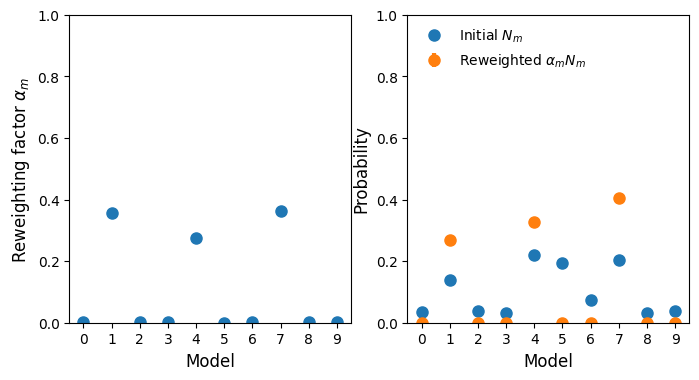

In [15]:
cluster_counts = np.loadtxt(filename_cluster_counts)
Nm = cluster_counts.astype(float)
Nm /= np.sum(Nm)

factor_mean, factor_std = np.loadtxt(output_directory+"reweighting_factor.txt", unpack=True)
M = len(factor_mean)

fig = plt.figure(figsize=(8, 4), dpi=100)
ax1 = fig.add_subplot(121)
ax1.errorbar(np.arange(M), factor_mean, yerr=factor_std, fmt='o')
ax1.set_xlabel("Model")
ax1.set_ylabel(r"Reweighting factor $\alpha_m$")

ax1.set_xticks(np.arange(0, M, 1))
ax1.set_yticks(np.arange(0,1.01,0.2))
ax1.set_xlim(-0.5, M-0.5)
ax1.set_ylim(0, 1.0)

rewtprob_mean, rewtprob_std = np.loadtxt(output_directory+"reweighted_prob.txt", unpack=True)
ax2 = fig.add_subplot(122)
ax2.plot(np.arange(M), Nm, 'o', label=r"Initial $N_m$")
ax2.errorbar(np.arange(M), rewtprob_mean, yerr=rewtprob_std, fmt='o', label=r"Reweighted $\alpha_m N_m$")
ax2.set_xlabel("Model")
ax2.set_ylabel("Probability")
ax2.legend(
    loc='upper left',
    frameon=False,
)

ax2.set_xticks(np.arange(0, M, 1))
ax2.set_yticks(np.arange(0,1.01,0.2))
ax2.set_xlim(-0.5, M-0.5)
ax2.set_ylim(0, 1.0)

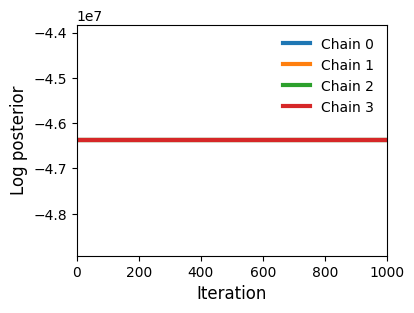

In [16]:
## Inspect the log posterior throughout the MCMC sampling
lp = np.loadtxt(output_directory+"/lp.txt")
fig = plt.figure(figsize=(4, 3), dpi=100)
ax = fig.add_subplot(111)
nChain = lp.shape[0]
for i in range(nChain):
    ax.plot(lp[i], label="Chain %d"%i)
ax.set_xlim(0, lp.shape[1])
ax.set_xlabel("Iteration")
ax.set_ylabel("Log posterior")
ax.legend(
    loc='upper right',
    frameon=False,
)
## Actually nothing to see because the log posterior already converge at burn-in, this example system is low dimensional and easy to sampl

Plot 2D free energy landscape

/var/folders/_8/h5rr6k3s2995tzxt8b9sqfgh0000gq/T/ipykernel_88300/1223149080.py:15: RuntimeWarning: divide by zero encountered in log
  y_init = -np.log(H_init)


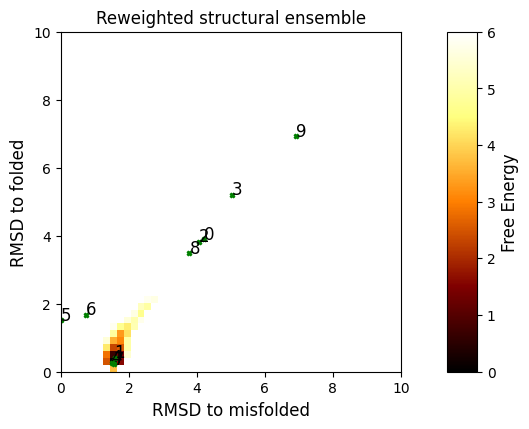

In [17]:
# Reweighted structural ensemble
cluster_labels = np.loadtxt(filename_cluster_labels, dtype=int)
weights = np.array(factor_mean)[cluster_labels]
fig = plt.figure()
ax = plot2DFreeEnergy(fig, rmsdTrajFolded, rmsdTrajMisfolded, weights = weights, nameCV1 = "RMSD to folded", nameCV2 = "RMSD to misfolded", title = "Reweighted structural ensemble")
ax.scatter(rmsdStrucMisfolded, rmsdStrucFolded, s=10, c='g', marker='X', label='Reference structure')
for i in range(nStruc):
    ax.annotate(i, (rmsdStrucMisfolded[i], rmsdStrucFolded[i]), fontsize=12)
plt.show()

Example script for perform K-Medoids clustering on trajectory

In [ ]:
### EXAMPLE ONLY, NOT RUNNABLE HERE, REQUIRES THE LONG TRAJECTORY FILE ###

import numpy as np
from tqdm import tqdm
import numpy as np
import time, os
import sys

### extra modules needed for this part
import mdtraj as md
import kmedoids
###

# load the trajectory

gro_file = "struc.gro"
xtc_file = "struc_whole_traj.xtc"
t = md.load(xtc_file, top=top_file)
atom_indices = [a.index for a in t.topology.atoms if a.name == 'CA']

# calculate pairwise RMSD
distances = np.empty((t.n_frames, t.n_frames), dtype=np.float32)
for i in tqdm(range(t.n_frames)):       # this is a long calculation!!
    distances[i,:] = md.rmsd(t, t, i, atom_indices=atom_indices, parallel=True)
print('Max pairwise rmsd: %f nm' % np.max(distances))
np.save("distances_self_pairwise.npy", distances)

# perform k-medoids clustering
nCluster = 10
c = kmedoids.fasterpam(distances, nCluster)
labels = c.labels
medoids = c.medoids
unique, counts = np.unique(labels, return_counts=True)

np.savetxt("cluster_labels.txt", labels, fmt="%d")      # save the cluster labels for each frame in the trajectory
np.savetxt("cluster_medoids.txt", medoids, fmt="%d")    # save the medoids as frame numbers in the trajectory
np.savetxt("cluster_counts.txt", counts, fmt="%d")      # save the number of members in each cluster